In [1]:
# enable autoreloading of modules
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import torch

torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from src.plotting import plot_2d_scatter, plot_histogram, plot_records_per_plane, plot_cone_with_scatter, plot_y_values_per_plane, generate_3d_cone_animation
from src.data_exploration import calculate_max_records_events, select_event_data, print_y_values_per_plane
from src.featurization import calcualte_cone_parameters


## Load data

In [4]:
hit_file = "../ml/processed_events/normalized_features.parquet"
train_data = pd.read_parquet(hit_file)

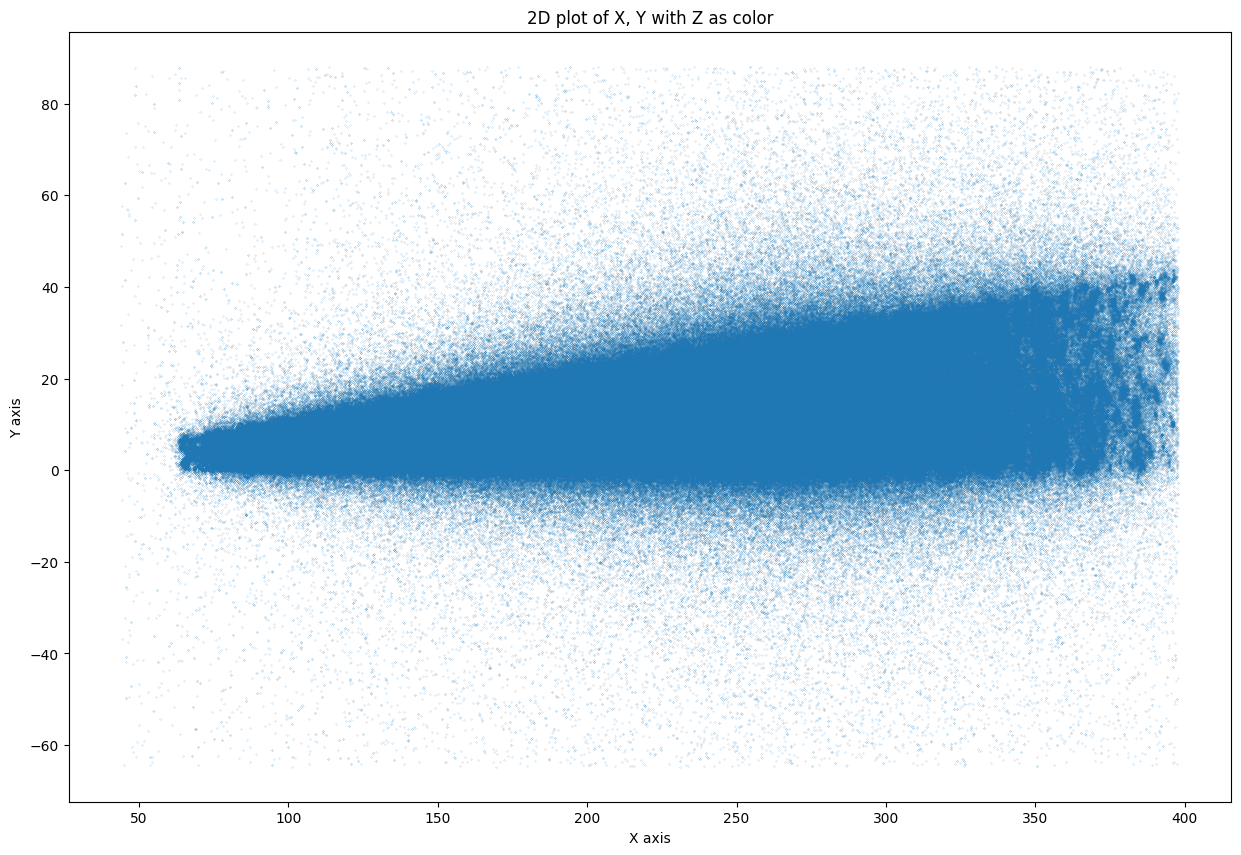

In [5]:
# 2d plot of x,y z, transfomed to 2d, from train_data
figure, ax = plot_2d_scatter(train_data)

## Plot histograms of all columns

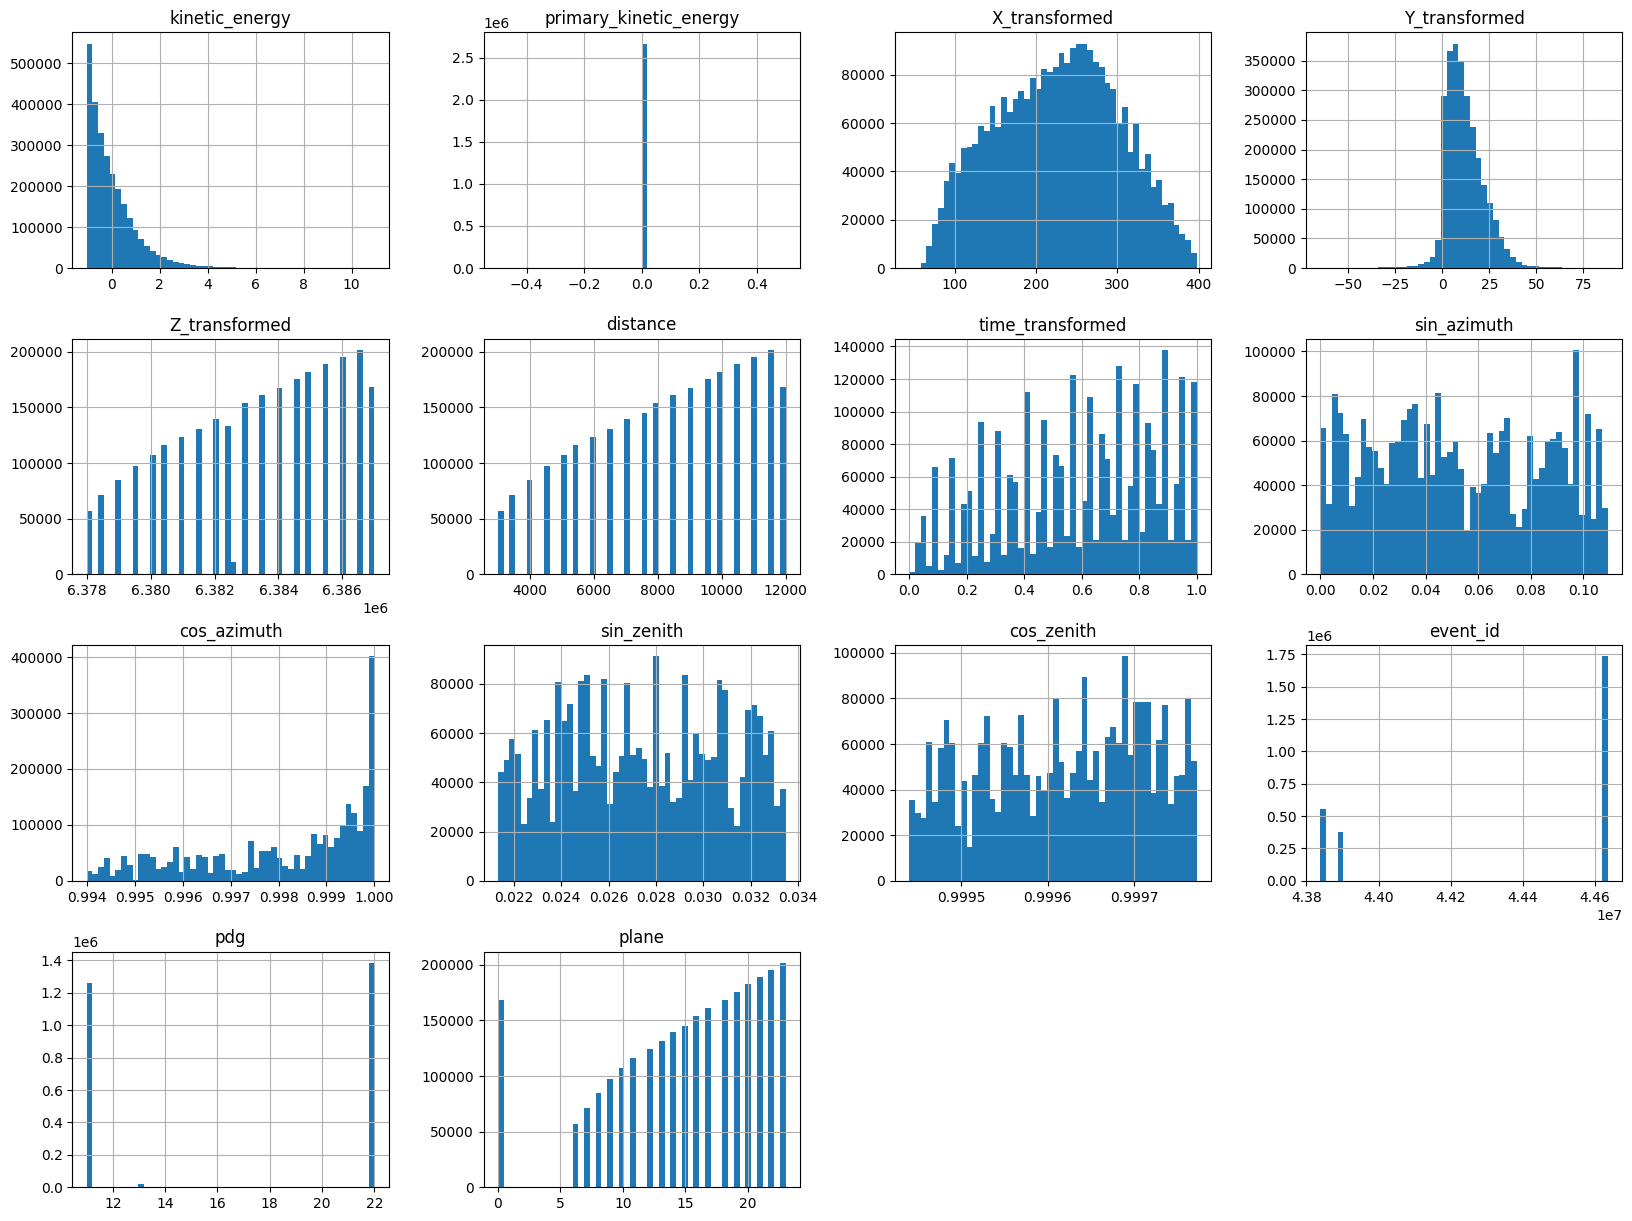

In [6]:
# plot histograms of each feature
axes = train_data.hist(bins=50, figsize=(20,15))

## Plot statistics for events

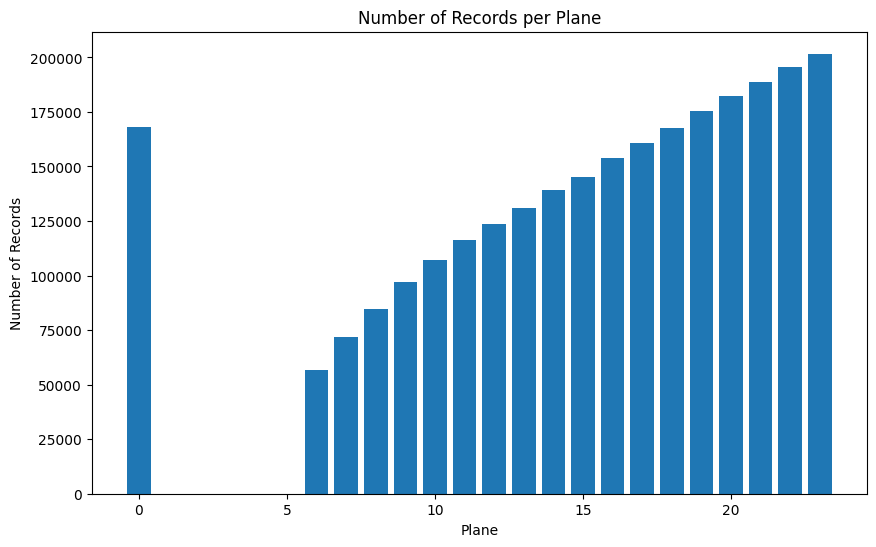

In [7]:
plot_records_per_plane(train_data)

In [8]:
# select top 10 event with most records
max_records_events = calculate_max_records_events(train_data)   
max_records_event = max_records_events[0]

Events with most records: Index([43888008.0, 43888065.0, 44634388.0, 44635212.0, 44634225.0, 43845485.0,
       43888348.0, 43887992.0, 44633576.0, 44633579.0],
      dtype='float64', name='event_id')


In [9]:
top_event_data = select_event_data(train_data, max_records_event)

In [10]:
top_event_data['plane'].unique()

array([22., 23.,  0., 20., 19., 18., 21., 17., 16., 15., 14., 13., 12.,
       10., 11.])

In [11]:
# change plane number 0 to 24 for all reccords in top_event_data after copying
top_event_data = top_event_data.copy()
top_event_data.loc[top_event_data['plane'] == 0, 'plane'] = 24

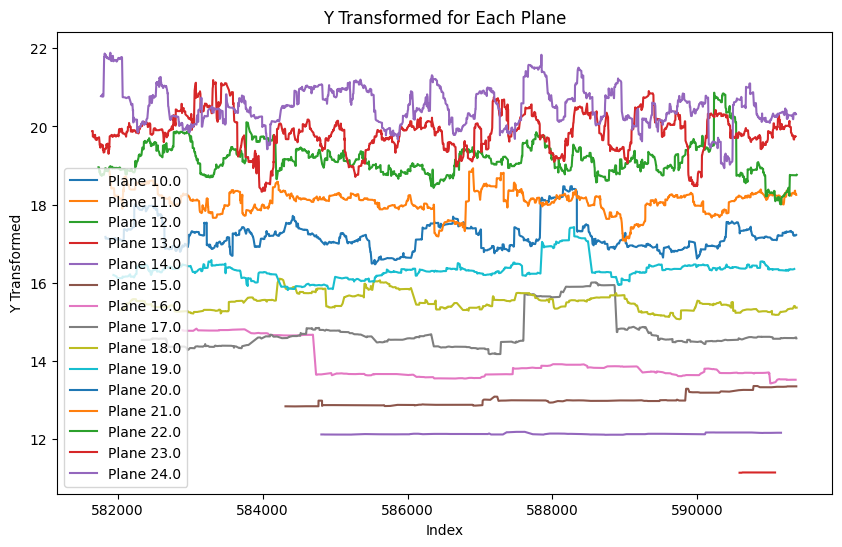

In [12]:
figure = plot_y_values_per_plane(top_event_data)

In [13]:
print_y_values_per_plane(top_event_data)

Plane 10.0: Mean Y Transformed = 8.5862
Plane 11.0: Mean Y Transformed = 9.4449
Plane 12.0: Mean Y Transformed = 10.3038
Plane 13.0: Mean Y Transformed = 11.1471
Plane 14.0: Mean Y Transformed = 12.1255
Plane 15.0: Mean Y Transformed = 13.0650
Plane 16.0: Mean Y Transformed = 13.8479
Plane 17.0: Mean Y Transformed = 14.6852
Plane 18.0: Mean Y Transformed = 15.4916
Plane 19.0: Mean Y Transformed = 16.3128
Plane 20.0: Mean Y Transformed = 17.1982
Plane 21.0: Mean Y Transformed = 18.1111
Plane 22.0: Mean Y Transformed = 19.1420
Plane 23.0: Mean Y Transformed = 19.8215
Plane 24.0: Mean Y Transformed = 20.5120


In [14]:
# generate_3d_cone_animation(top_event_data, output_folder="cone_frames")

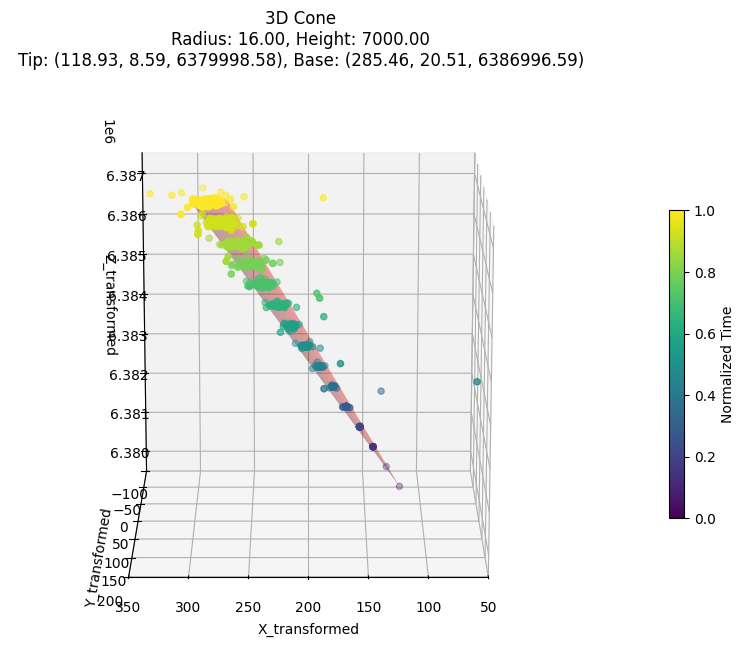

In [15]:
fig, ax = plot_cone_with_scatter(top_event_data, elev=15., azim=90)
plt.show()

# Prepare training data

Select input and output columns

In [16]:
import sklearn as sk
from sklearn.model_selection import train_test_split

input_columns = [
            "primary_kinetic_energy",
            "sin_azimuth", "cos_azimuth", "sin_zenith", "cos_zenith"
        ]
output_columns = [
            "kinetic_energy", 
            "X_transformed", "Y_transformed", "Z_transformed",
        ]
batch_identifier = "event_id"

Calculate meand and std of secondary features

In [17]:
event_stats = train_data

# apply function for each event
event_cone_params = event_stats.groupby(by=[batch_identifier]).apply(calcualte_cone_parameters).reset_index()

# group input features by event_id and drop the rest of the columns
train_data_inputs = train_data.groupby(by=input_columns+[batch_identifier]).first().reset_index()
train_data_inputs = train_data_inputs[input_columns + [batch_identifier]]

# joint to train_data[input_columns] on event_id
train_data_with_cone = train_data_inputs.merge(event_cone_params, on=batch_identifier, how='inner') 

# update output columns
output_columns = [
    'X_mean_min', 'Y_mean_min', 'Z_mean_min',
    'X_mean_max', 'Y_mean_max', 'Z_mean_max',
    'radius'
]

/tmp/ipykernel_55605/1446540073.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_cone_params = event_stats.groupby(by=[batch_identifier]).apply(calcualte_cone_parameters).reset_index()


Impute nan values

In [18]:
# impute na with 0
train_data_with_cone = train_data_with_cone.dropna()

# Define NN using PINA

Test train split

In [19]:
from sklearn.preprocessing import StandardScaler

# split inputs and outputs 
X = train_data_with_cone[input_columns]
y = train_data_with_cone[output_columns]

# create scaler for each output column
y_scaler = StandardScaler()

# fit and transform each column separately
y_normalized = y_scaler.fit_transform(y)

PINA

In [20]:
from pina import Trainer, Condition, LabelTensor
from pina.problem import AbstractProblem
from src.nn import Model, Discriminator, Generator
from pina.optim import TorchOptimizer, TorchScheduler
from pina.solver import GAROM
from pina.callback import MetricTracker
import torch



In [21]:
x_pina = X.values
y_pina = y_normalized

In [22]:
class ParticleProblem(AbstractProblem):

    output_variables = output_columns
    input_variables = input_columns
    conditions = {
        "data": Condition(
            input=torch.tensor(x_pina, dtype=torch.float32),
            target=torch.tensor(y_pina, dtype=torch.float32)
        )
    }


problem = ParticleProblem()

In [23]:
generator =  Generator(
      parameters_dimension=len(problem.input_variables),
      input_dimension=len(problem.output_variables),
      activation=torch.nn.Tanh
  )

optimizer = TorchOptimizer(torch.optim.RAdam, lr=0.02)

scheduler = TorchScheduler(torch.optim.lr_scheduler.MultiStepLR, milestones=[100, 200, 600, 1000, 1600, 3000], gamma=0.5)

In [25]:
discriminator = Discriminator(
    input_dimension=len(problem.output_variables),
    parameter_dimension=len(problem.input_variables),
    hidden_dimension=5
    )

In [26]:
solver = GAROM(
    problem,
    generator,
    discriminator,
    optimizer_generator=optimizer,
    scheduler_generator=scheduler
    )

In [27]:
# create the trainer
trainer = Trainer(
    solver=solver,  # The ensemble solver
    max_epochs=1000,  # Maximum number of training epochs
    logger=True,  # Enables logging (default logger is CSVLogger)
    callbacks=[MetricTracker()],  # Tracks training metrics using MetricTracker
    accelerator="cpu",  # Use CPU for training, alternative is "gpu" for GPU training
    train_size=0.7,  # Fraction of the dataset used for training (70%)
    test_size=0.2,  # Fraction of the dataset used for testing (20%)
    val_size=0.1,  # Fraction of the dataset used for validation (10%)
)

import time

start = time.time()
# train
trainer.train()
end = time.time()
print(f"Training time: {end - start} seconds")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 3.5 K  | train
1 | _loss_fn     | PowerLoss  | 0      | train
----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s, v_num=128]          
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 27.93it/s, v_num=128, val_loss=0.785, d_loss=0.757, g_loss=0.143, stability_metric=0.843, data_loss=0.767, train_loss=0.767]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s, v_num=128, val_loss=0.785, d_loss=0.756, g_loss=0.136, stability_metric=0.847, data_loss=0.766, train_loss=0.766]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 35.09it/s, v_num=128, val_loss=0.785, d_loss=0.755, g_loss=0.130, stability_metric=0.852, data_loss=0.766, train_loss=0.766]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 20.33

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=128, val_loss=0.976, d_loss=0.111, g_loss=0.0274, stability_metric=0.122, data_loss=0.957, train_loss=0.957]
Training time: 103.52736377716064 seconds


Plot loss

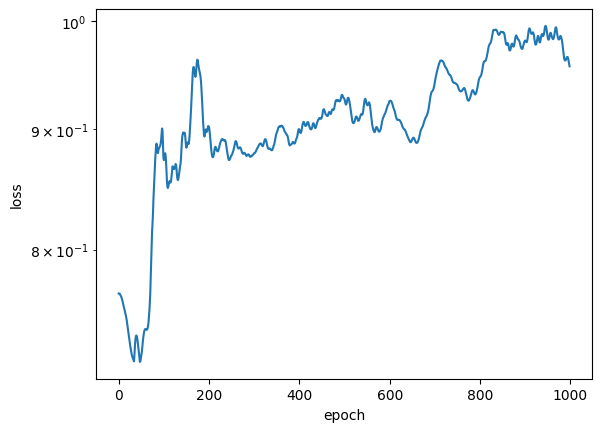

In [28]:
# plot loss
trainer_metrics = trainer.callbacks[0].metrics
loss = trainer_metrics["train_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss.cpu())
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

# Test NN: Plot errors in output/target features

In [29]:
all_outputs = None
all_targets = None

trainer.data_module.setup("test")
with torch.no_grad():
    for data in trainer.data_module.test_dataloader():
    # for data in trainer.data_module.train_dataloader():
        inputs, target = data[0][1]["input"], data[0][1]["target"]
        outputs = solver(inputs)

        if all_outputs is None:
            all_outputs = LabelTensor(outputs, labels=output_columns)
            all_targets = target
        else:
            all_outputs.append(LabelTensor(outputs, labels=output_columns))
            all_targets.append(target)
        break

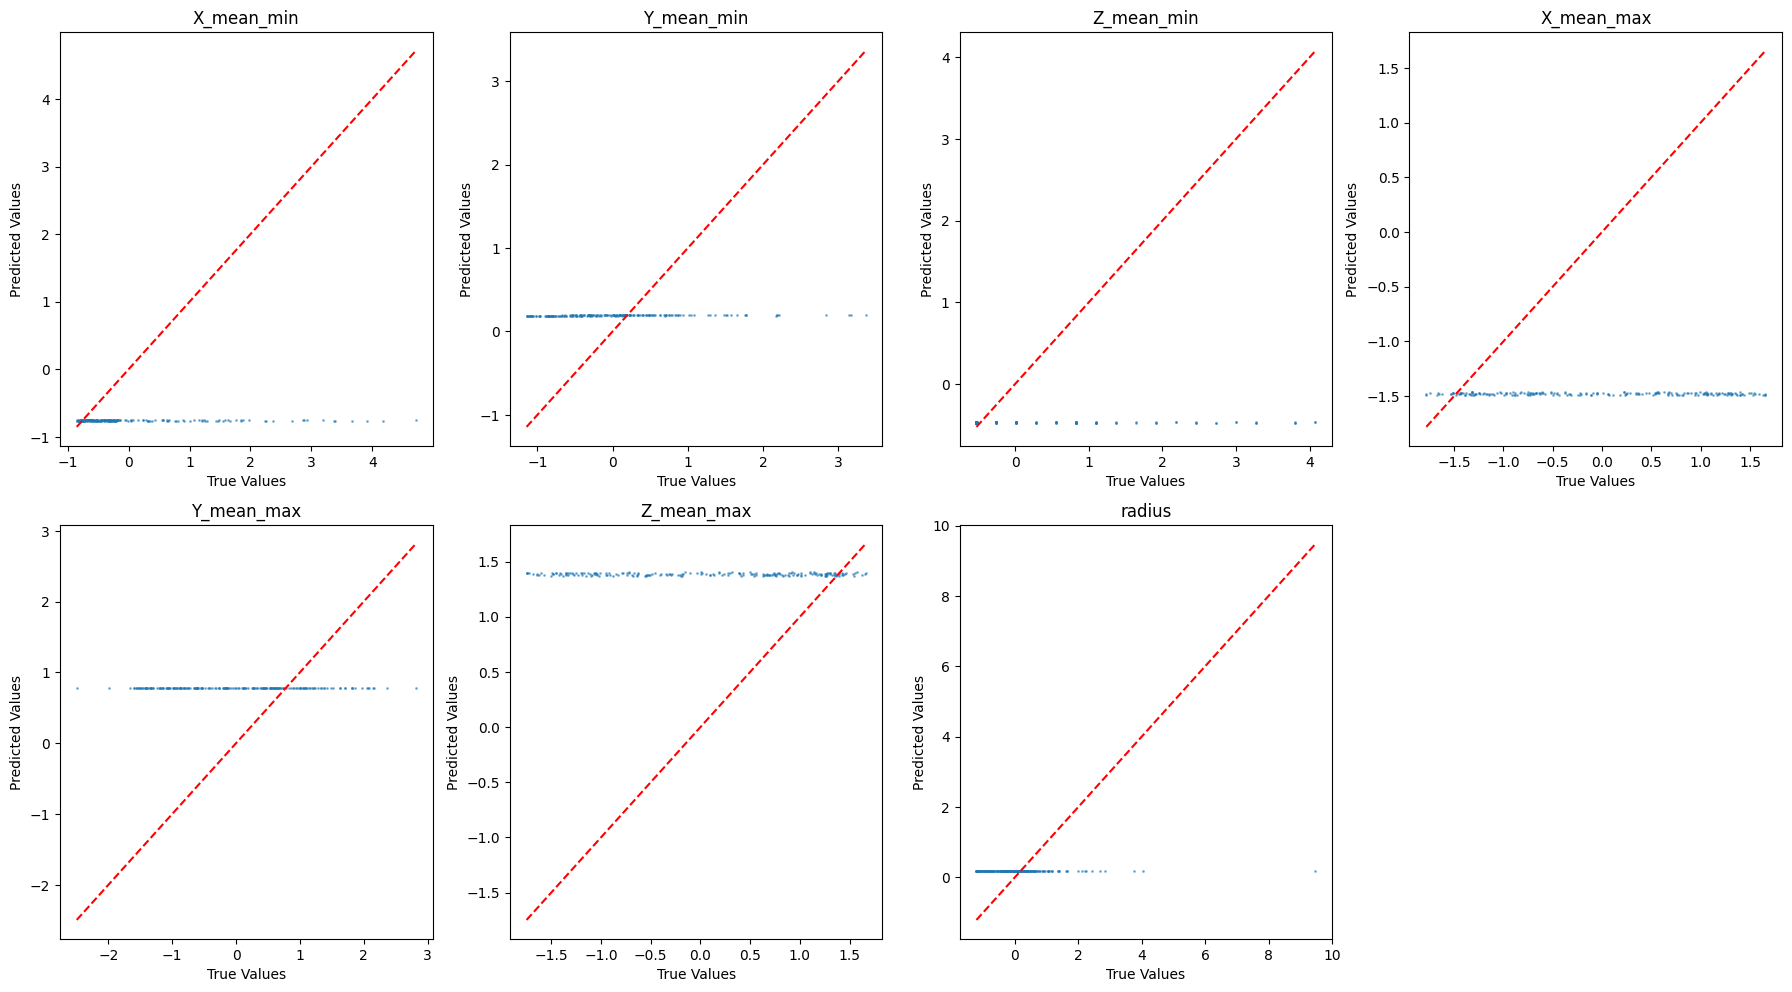

In [37]:
# plot targets vs predictions for validation set
y_hat = all_outputs.detach()
true_output = all_targets.detach()

plt.figure(figsize=(18, 10))
# use 3 columns per row
for i, col in enumerate(output_columns):
    plt.subplot(len(output_columns)//4+1, 4, i+1)
    plt.scatter(true_output[:, i], y_hat[:, i], alpha=0.5, s=1)
    plt.plot([true_output[:, i].min(), true_output[:, i].max()],
             [true_output[:, i].min(), true_output[:, i].max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(col)
plt.tight_layout(pad=1.0)